## Housing Prices

### 1. Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os

from scipy import stats
from scipy.stats import norm
from scipy.stats import pointbiserialr
from scipy.stats import f_oneway

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import StandardScaler

from lightgbm import LGBMRegressor

### 2. Import Data

In [2]:
dir = os.getcwd()
train_data = pd.read_csv(os.path.join(dir,'input', 'train.csv'))
test_data = pd.read_csv(os.path.join(dir,'input', 'test.csv'))

### 3. Exploratory Data Analysis (EDA)

In [3]:
def basic_eda_info (df, name='DataFrame'):

    print(f'=== {name}: Basic Information ===')
    print(f'Shape: {df.shape}')

    print('='*60)
    print('=== Head of DataFrame ===')
    display(df.head())

    with pd.option_context('display.float_format', '{:,.2f}'.format):
        print('=== Numeric Describe ===')
        display(df.describe())
    
    print('='*60)
    print('=== Missing Values ===')
    missing_values = df.isna().sum()
    missing_values = missing_values[missing_values != 0]
    missing_values = missing_values.sort_values(ascending=False)
    print(missing_values)
    print('=' * 60)

In [4]:
def correlation_analysis_type(X, y, task="classification", numeric_cols=None, threshold=0.5, graphic='yes'):
    """
    Function to analyze correlations based on the task (classification or regression)
    and plot a heatmap of correlations.

    Returns:
    - Displays a heatmap of correlations for the specified task.
    - The correlation matrix.
    """
    if numeric_cols is None:
        numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()

    if task == "classification":
        if pd.Series(y).nunique() > 2:
            raise ValueError("For classification, the target variable (y) must be binary (e.g., 0 or 1).")

        correlations = {}
        for col in numeric_cols:
            corr, _ = pointbiserialr(y, X[col])
            correlations[col] = corr
        
        # Convert to DataFrame for visualization
        corr_df = pd.DataFrame.from_dict(correlations, orient='index', columns=['Correlation'])
        corr_df = corr_df.sort_values(by='Correlation', ascending=False)

        if graphic == 'yes':
            # Plot heatmap
            plt.figure(figsize=(6, 4))
            sns.heatmap(corr_df, annot=True, cmap='coolwarm', cbar=False, fmt='.2f')
            plt.title('Point-Biserial Correlation Heatmap (Classification)')
            plt.show()

        return corr_df

    elif task == "regression":
        # Combine X and y temporarily for correlation calculation
        combined_df = X[numeric_cols].copy()
        combined_df["Target"] = y

        # Compute correlation matrix
        corr_df = combined_df.corr()
        filtered_corr = corr_df[((corr_df > threshold) | (corr_df < -threshold)) & (corr_df != 1) & (corr_df != -1)]
        filtered_corr = filtered_corr.dropna(axis=0, how='all') #drop NaN rows
        filtered_corr = filtered_corr.dropna(axis=1, how='all') #drop NaN columns
        
        if graphic == 'yes': 
            # Plot heatmap
            plt.figure(figsize=(20, 10))
            # sns.heatmap(corr_df, annot=True, cmap='coolwarm', fmt='.2f')
            sns.heatmap(filtered_corr, annot=True, cmap='coolwarm', fmt='.2f')
            plt.title('Correlation Heatmap (Regression)')
            plt.show()

        return filtered_corr
    
    else:
        raise ValueError("Invalid task. Please choose 'classification' or 'regression'.")
    
# If two variables are highly correlated (GarageCars & GarageArea), consider keeping the one with:
# Stronger correlation to the target variable.
# More interpretability or importance in your domain knowledge.
# Or, consider combining them into a single feature like GarageSize (GC*GA)

In [5]:
def categorical_continuous_analysis(df, target, p_threshold=0.05, std_multiplier=0.15):
    results = {}
    cat_cols = df.select_dtypes(include='object').columns
    target_std = df[target].std()
    std_threshold = target_std * std_multiplier
    
    for col in cat_cols:
        groups = [df[df[col] == val][target].dropna() for val in df[col].dropna().unique()]
        
        # Skip if there's only one group
        if len(groups) <= 1:
            continue
        
        try:
            # ANOVA F-test
            f_val, p_val = f_oneway(*groups)
        except:
            f_val, p_val = float('nan'), float('nan')
        
        # Mean encoding analysis
        mean_per_cat = df.groupby(col)[target].mean()
        std_dev = mean_per_cat.std()
        mean_range = mean_per_cat.max() - mean_per_cat.min()
        
        # Decision criteria
        keep = "Yes" if (p_val < p_threshold and std_dev > std_threshold) else "No"

        results[col] = {
            'F-statistic': f_val,
            'P-Value': p_val,
            'Mean STD': std_dev,
            'Mean Range': mean_range,
            'Keep': keep
        }

    return pd.DataFrame(results).T.sort_values(by='Keep', ascending=False)

# In many real estate datasets (like Ames Housing or similar):
# SalePrice usually ranges from $50,000 to $500,000+.
# A standard deviation of $10,000+ in group means implies:
# Price varies quite a bit between categories.
# The categorical variable likely captures useful structure in price (e.g., Neighborhood, HouseStyle).

In [6]:
def y_distribution(y):
    # Plot the histogram with Kernel Density Estimate (KDE)
    sns.histplot(y, kde=True, stat='density', label="Data")
    
    # Overlay the normal distribution curve using Seaborn
    sns.kdeplot(y, label="Normal Fit", color='red', linestyle="--")
    
    # Add titles and legend
    plt.title("Distribution of y with Normal Fit")
    plt.legend()
    plt.show()

    # Q-Q plot for normality assessment
    stats.probplot(y, plot=plt)
    plt.title("Q-Q Plot of y")
    plt.show()

### 4. Practice Dataset - EDA

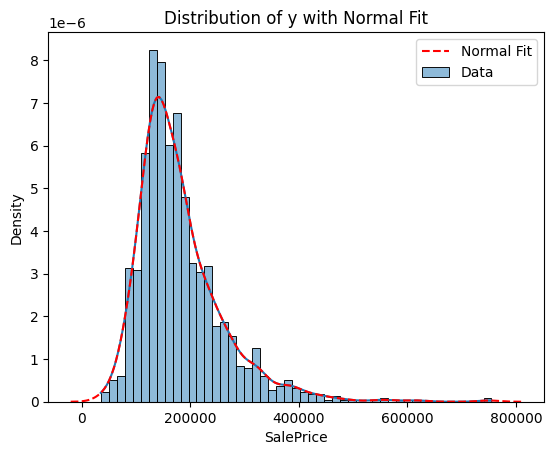

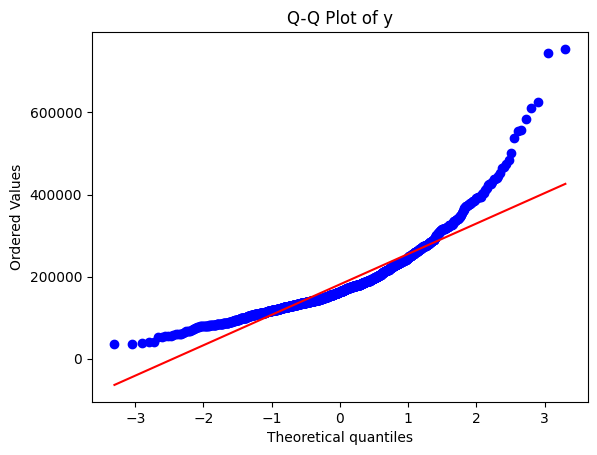

In [7]:
y_distribution(train_data['SalePrice'])

# Ok, 'SalePrice' is not normal. It shows positive skewness and does not follow the diagonal line.
# A simple data transformation can solve the problem.
# In case of positive skewness, log transformations usually works well.

In [8]:
# basic_eda_info(train_data)

In [9]:
# categorical_results = categorical_discrete_analysis(train_data, 'SalePrice',chi2_threshold=0.05)
# categorical_to_select = list(categorical_results.loc[categorical_results.Keep == "Yes"].index)
# categorical_to_select
# categorical_results

In [10]:
categorical_results = categorical_continuous_analysis(train_data, 'SalePrice')
# categorical_results

In [11]:
categorical_to_select = list(categorical_results.loc[categorical_results.Keep == "Yes"].index)
missing_data(train_data[categorical_to_select])
# missing_data(test_data[categorical_to_select])

NameError: name 'missing_data' is not defined

### 5. Data Cleaning

#### 5.1 Missing data

In [12]:
def missing_data(df, threshold = 0.5):
    print(" " * 50)
    print(f"Missing in df:")
    print("." * 50)
    
    missing_values = df.isna().sum()
    missing_values = missing_values[missing_values != 0]  # Filter out columns with no missing values
    # missing_values = missing_values.sort_values(ascending=False)
    
    total_rows = len(df)
    missing_percent = ((missing_values / total_rows) * 100).round(2)  # Percentage of missing values
    analysis = ["Delete" if percent > threshold*100 else "Keep" for percent in missing_percent]

    # Combine into a DataFrame
    missing_summary = pd.DataFrame({
        'Missing Values': missing_values,
        'Percent': missing_percent,
        'Analysis' : analysis
    })

    # Sort by the number of missing values
    missing_summary = missing_summary.sort_values(by='Missing Values', ascending=False)
    
    return missing_summary

#### 5.2 Missing data on BsmtQual

In [13]:
def replace_BsmtQual (df):
    df['BsmtQual'] = df['BsmtQual'].fillna('TA')

    return df

#### 5.3 Missing data on MasVnrArea

In [14]:
def replace_MasVnrArea (df):
    df['MasVnrArea'] = df['MasVnrArea'].fillna(0)

    return df

#### 5.4 Missing data on Test_DF

In [15]:
def replace_on_test (df):

    # Replace categorical missing values with the mode for each column only when is really big the missing
    
    # Replace numerical missing values
    df['GarageCars'] = df['GarageCars'].fillna(0)
    df['GarageArea'] = df['GarageArea'].fillna(0)
    df['TotalBsmtSF'] = df['TotalBsmtSF'].fillna(df['TotalBsmtSF'].mean())
    
    return df

### 6. Featuring Engineering

#### 6.1 Merging supplementary data

In [16]:
def add_features_columns (df):
    # Add ratios or flags, not arithmethics values

    df['Property_Age'] = df['YrSold'] - df['YearBuilt']
    df['Years_Remodel'] = df['YrSold'] - df['YearRemodAdd']
    df['Has_2nd_Floor'] = (df['2ndFlrSF'] > 0).astype(int)
    df['Bedroom_Ratio'] = df['BedroomAbvGr'] / df['TotRmsAbvGrd']
    df['Has_Garage'] = df['GarageCars'].apply(lambda x: 1 if x>0 else 0)
    df['Large_Garage'] = (df['GarageCars'] >=3).astype(int)

    return df

In [17]:
def add_factorize_or_encode(X_train, X_valid, X_test, task="classification"):
    """
    Automatically handle categorical features for classification or regression tasks.
    Applies encoding consistently across train, validation, and test sets.
    """
    categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns

    if task == "classification":
        if len(categorical_cols) > 0:
            print(f"Encoding categorical columns: {list(categorical_cols)}")
            for col in categorical_cols:
                encoder = LabelEncoder()
                X_train[col] = encoder.fit_transform(X_train[col].astype(str))
                X_valid[col] = encoder.transform(X_valid[col].astype(str))
                X_test[col] = encoder.transform(X_test[col].astype(str))

    elif task == "regression":
        if len(categorical_cols) > 0:
            print(f"One-hot encoding categorical columns: {list(categorical_cols)}")

            encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown="ignore")

            # Fit encoder and transform datasets
            X_train_encoded = pd.DataFrame(
                encoder.fit_transform(X_train[categorical_cols]),
                columns=encoder.get_feature_names_out(categorical_cols),
                index=X_train.index
            )
            X_valid_encoded = pd.DataFrame(
                encoder.transform(X_valid[categorical_cols]),
                columns=encoder.get_feature_names_out(categorical_cols),
                index=X_valid.index
            )
            X_test_encoded = pd.DataFrame(
                encoder.transform(X_test[categorical_cols]),
                columns=encoder.get_feature_names_out(categorical_cols),
                index=X_test.index
            )

            # Reindex validation and test sets to match training columns
            X_valid_encoded = X_valid_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)
            X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

            # Drop original categorical columns and concatenate encoded ones
            X_train = pd.concat([X_train.drop(columns=categorical_cols), X_train_encoded], axis=1)
            X_valid = pd.concat([X_valid.drop(columns=categorical_cols), X_valid_encoded], axis=1)
            X_test = pd.concat([X_test.drop(columns=categorical_cols), X_test_encoded], axis=1)

            # Ensure no NaN values after encoding
            X_train.fillna(0, inplace=True)
            X_valid.fillna(0, inplace=True)
            X_test.fillna(0, inplace=True)

    else:
        raise ValueError("Invalid task. Please choose 'classification' or 'regression'.")

    return X_train, X_valid, X_test


#### 6.2 Standarizing the data

In [18]:
def discretise_numeric(X_train, X_val, X_test, numeric_cols, no_bins=10, strategy='uniform'):
    """
    Discretizes the specified numeric columns into bins for X_train, X_val, and X_test using KBinsDiscretizer.
    The binning is fitted on X_train and then applied to X_val and X_test to avoid data leakage.
    Ensures no NaN values by using ordinal encoding.
    
    Parameters:
    - strategy: Binning strategy ('uniform', 'quantile', 'kmeans')
    """
    # Copy inputs to avoid modifying the original datasets
    X_train = X_train.copy()
    X_val = X_val.copy()
    X_test = X_test.copy()
    
    # Apply KBinsDiscretizer
    discretizer = KBinsDiscretizer(n_bins=no_bins, encode='ordinal', strategy=strategy)
    
    # Fit on X_train
    X_train[numeric_cols] = discretizer.fit_transform(X_train[numeric_cols])
    
    # Transform X_val and X_test using the same discretizer
    X_val[numeric_cols] = discretizer.transform(X_val[numeric_cols])
    X_test[numeric_cols] = discretizer.transform(X_test[numeric_cols])
    
    return X_train, X_val, X_test

In [19]:
def standardize_values(X_train, X_val, X_test, numeric_cols):
    """
    Standardizes specified numeric columns in X_train, X_val, and X_test.
    The scaler is fitted on X_train and applied to X_val and X_test.
    """
    # Ensure inputs are copies to avoid modifying the original datasets
    X_train = X_train.copy()
    X_val = X_val.copy()
    X_test = X_test.copy()

    # Initialize the scaler
    scaler = StandardScaler()

    # Fit the scaler on X_train
    scaler.fit(X_train[numeric_cols])

    # Transform X_train, X_val and X_test
    X_train[numeric_cols] = scaler.transform(X_train[numeric_cols])
    X_val[numeric_cols] = scaler.transform(X_val[numeric_cols])
    X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

    return X_train, X_val, X_test

In [20]:
def equal_dataframes(X_train, X_val, X_test):
    """
    Aligns X_train, X_val, and X_test to have the same columns by adding missing columns
    or removing extra columns.
    """
    # Ensure inputs are copies to avoid modifying original data
    X_train = X_train.copy()
    X_val = X_val.copy()
    X_test = X_test.copy()

    # Reference columns from X_train
    common_columns = X_train.columns

    # Add missing columns to X_val and X_test (with default values as 0)
    for col in common_columns:
        if col not in X_val.columns:
            X_val[col] = 0
        if col not in X_test.columns:
            X_test[col] = 0

    # Remove extra columns in X_val and X_test that are not in X_train
    X_val = X_val[common_columns]
    X_test = X_test[common_columns]

    return X_train, X_val, X_test

In [21]:
def calculate_vif(df):
    """
    Calculate VIF (Variance Inflation Factor) for each feature in the dataset.
    VIF quantifies how much the variance of a predictor is inflated due to multicollinearity with other predictors.
    A higher VIF indicates stronger collinearity.

    How to Interpret VIF:
    VIF < 5: Low multicolinearity, safe to include
    VIF 5-10: Moderate multicolinearity, may need attention
    VIF > 10: High multicolinearity, consider removing or transforming the numerical column
    """

    vif_data = pd.DataFrame()
    numeric_cols = df.select_dtypes(include=[np.number]).columns.to_list()
    vif_data["numeric_cols"] = numeric_cols
    vif_data["VIF"] = [
        variance_inflation_factor(df[numeric_cols].values, i)
        for i in range(len(numeric_cols))
    ]
    
    vif_data["VIF"] = vif_data["VIF"].round(2)

    vif_data["Analysis"] = vif_data["VIF"].apply(
        lambda x: "Include" if x < 5 else ("Check" if 5 <= x < 10 else "Delete")
    )

    vif_data = vif_data.sort_values(by="VIF", ascending=False).reset_index(drop=True)
    
    return vif_data

#### 6.3 Final features & cleaning selection

In [22]:
def pre_clean_df (df, selected_columns):
    
    #Only to show missing data from selected columns
    df = add_features_columns(df)
    df = df[selected_columns]
    missing_data (df)


In [23]:
def clean_df (df, selected_columns, drop_columns):
    
    # Do all the steps together
    df = replace_BsmtQual(df)
    df = replace_MasVnrArea(df)
    df = replace_on_test(df)
    df = add_features_columns(df)
    df = df[selected_columns]
    missing_data (df)
    df = df.drop(drop_columns, axis=1)
    
    return df

In [24]:
def binary_columns (df):
    binary_cols = df.select_dtypes(include=['number']).columns[
        (df.min() == 0) & (df.max() == 1)
    ]
    return list(binary_cols)

In [25]:
def numerical_non_binary_columns (df):
    numeric_cols = df.select_dtypes(include=['number'])

    non_binary_numeric_cols = numeric_cols.loc[:, ~((numeric_cols.min() == 0) & (numeric_cols.max() == 1))]

    return list(non_binary_numeric_cols.columns)

### 7. Practice Dataset - Analysis & premodeling work

In [26]:
selected_columns = ["Id", "MSZoning", "LotArea", "LotShape", "LotConfig", "Neighborhood", "OverallQual", "Property_Age", "Years_Remodel", "MasVnrArea", "ExterCond", "Foundation",
                     "BsmtQual", "Heating", "Has_2nd_Floor", "GrLivArea", "FullBath", "KitchenQual", "Bedroom_Ratio", "Fireplaces", "Has_Garage", "Large_Garage", "SaleType",
                     "SaleCondition"]
to_delete_columns = ["YearBuilt", "YearRemodAdd", "GarageCars", 'YrSold']
dependent = ["SalePrice"]
numeric_cols = [cname for cname in train_data.columns if train_data[cname].dtype in ['int64', 'float64'] and cname not in ['SalePrice', 'GarageYrBlt', 'LotFrontage']]

selected_columnsx = list(set(selected_columns+to_delete_columns+numeric_cols))

# pre_clean_df(train_data, selected_columns + dependent + to_delete_columns)
# pre_clean_df(test_data, selected_columns + to_delete_columns)

train_data_OL = train_data.drop(train_data[(train_data['GrLivArea']>4000) & (train_data['SalePrice']<300000)].index)
train_data_OL.reset_index(inplace=True)

X_train_clean = clean_df(train_data_OL, selected_columnsx + dependent, to_delete_columns)
X_test_clean = clean_df(test_data, selected_columnsx, to_delete_columns)
X_test_clean = X_test_clean.fillna(0)

train_numerical = numerical_non_binary_columns(X_train_clean) #Includes SalePrice
test_numerical = numerical_non_binary_columns(X_test_clean)

X = X_train_clean.drop(['SalePrice'], axis=1)
y = X_train_clean.SalePrice

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, X_test_clean = add_factorize_or_encode(X_train, X_val, X_test_clean, task="regression")

# Only discretise numerical columns, not binaries
X_tr_dn, X_va_dn, X_te_dn = discretise_numeric (X_train, X_val, X_test_clean, numeric_cols=['Property_Age', 'Years_Remodel'])

# # Only standarize numerical columns, not discrets, not binaries
X_tr_st, X_va_st, X_te_st = standardize_values(X_tr_dn, X_va_dn, X_te_dn, numeric_cols= [col for col in train_numerical if col not in ['SalePrice', 'Id']])
train_final, valid_final, test_final = equal_dataframes(X_tr_st, X_va_st, X_te_st)

train_final = train_final.set_index('Id')
valid_final = valid_final.set_index('Id')
test_final = test_final.set_index('Id')

                                                  
Missing in df:
..................................................
                                                  
Missing in df:
..................................................
One-hot encoding categorical columns: ['SaleCondition', 'KitchenQual', 'Heating', 'LotShape', 'Foundation', 'MSZoning', 'SaleType', 'Neighborhood', 'LotConfig', 'ExterCond', 'BsmtQual']


d:\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
d:\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [1, 5, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [27]:
# Analyze VIF to test Multicollinearity among predictors
vif_results = calculate_vif(X_train_clean[numerical_non_binary_columns(X_train_clean)])
vif_results[vif_results['Analysis'] == 'Delete'] #--> Remove columns that have inf VIF, this means that there is perfect multicollinearity


d:\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
d:\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
d:\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
d:\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
d:\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
d:\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered

,numeric_cols,VIF,Analysis
0,2ndFlrSF,inf,Delete
1,LowQualFinSF,inf,Delete
2,BsmtFinSF2,inf,Delete
3,BsmtUnfSF,inf,Delete
4,BsmtFinSF1,inf,Delete
5,TotalBsmtSF,inf,Delete
6,GrLivArea,inf,Delete
7,1stFlrSF,inf,Delete
8,TotRmsAbvGrd,83.49,Delete
9,OverallQual,58.79,Delete


In [79]:
corr_matrix = correlation_analysis_type (train_final, y_train, "regression", graphic='no', threshold=0.4, numeric_cols=numerical_non_binary_columns(train_final))

### 8. Prediction and Submission

In [28]:
# Initialize the model with the best parameters
best_model = LGBMRegressor(n_estimators=100, max_depth=15, learning_rate=0.05, random_state=42, early_stopping_rounds=5, verbosity=-1, num_leaves=31, colsample_bytree=0.8) #Best option

# Fit the model on the full training dataset
best_model.fit(train_final, y_train, eval_set=[(valid_final, y_val)]) #LGBM

# Predict on the valid data
predictions = best_model.predict(valid_final).astype('float').round(2)

MSE = round(mean_squared_error(y_val, predictions),2)

MAE = round(mean_absolute_error(y_val, predictions),2)

print(f'MSE: {MSE} \nMAE: {MAE}')

MSE: 526796053.8 
MAE: 15677.68


In [29]:
# Predict on the test data
predictions = best_model.predict(test_final).astype('float').round(2)

# Export to .csv file
output = pd.DataFrame({'Id': test_final.index, 'SalePrice': predictions})
output.to_csv('submission.csv', index=False)
print('Done')

Done
